<a href="https://colab.research.google.com/github/abuwildanm/food-recognition/blob/master/Create_Dataset_For_Vertex_AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Create Dataset For Vertex AI

## Download dataset from Google Cloud Storage

In [1]:
# Login to our GCP account
!gcloud auth login

Go to the following link in your browser:

    https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcloud-platform+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fappengine.admin+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcompute+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Faccounts.reauth&state=eOngMlhUu6IavQ2aM8pWyZpYTwy0Iu&prompt=consent&access_type=offline&code_challenge=tAfaaLzWp-VU9hsa6fKWewIkYh2lVgWEAD1OokntwcY&code_challenge_method=S256

Enter verification code: 4/1AY0e-g4jDGL3UhuK9I_2yV76K3Fyl2NimtF2zO2lMnr5md09AR2AkHryDVA

You are now logged in as [abuwildanm@gmail.com].
Your current project is [None].  You can change this setting by running:
  $ gcloud config set project PROJECT_ID


To take a quick anonymous survey, run:
  $ gcloud survey



In [2]:
# Set project using our project ID
!gcloud config set project food-nutrition-312416

Updated property [core/project].


In [3]:
# Check the number of file in bucket
!gsutil ls -lR gs://food-nutrition/dataset | tail -n 1

TOTAL: 973 objects, 8041614 bytes (7.67 MiB)


In [4]:
# Download dataset from our bucket
!gsutil -m cp -r gs://food-nutrition/dataset .

Copying gs://food-nutrition/dataset/test/omelette/classes.txt...
Copying gs://food-nutrition/dataset/test/omelette/omelette-100.jpg...
Copying gs://food-nutrition/dataset/predefined-classes.txt...
Copying gs://food-nutrition/dataset/test/omelette/omelette-100.txt...
Copying gs://food-nutrition/dataset/test/omelette/omelette-116.jpg...
Copying gs://food-nutrition/dataset/test/omelette/omelette-116.txt...
Copying gs://food-nutrition/dataset/test/omelette/omelette-118.jpg...
Copying gs://food-nutrition/dataset/test/omelette/omelette-118.txt...
Copying gs://food-nutrition/dataset/test/omelette/omelette-119.jpg...
Copying gs://food-nutrition/dataset/test/omelette/omelette-119.txt...
Copying gs://food-nutrition/dataset/test/omelette/omelette-59.jpg...
Copying gs://food-nutrition/dataset/test/omelette/omelette-59.txt...
Copying gs://food-nutrition/dataset/test/omelette/omelette-74.jpg...
Copying gs://food-nutrition/dataset/test/omelette/omelette-74.txt...
Copying gs://food-nutrition/dataset/t

## View the dataset

In [5]:
%cd /content/

/content


In [6]:
import os
from glob import glob

with open('/content/dataset/predefined-classes.txt') as f:
    categories = f.read().splitlines()

print('Number of train images:')
for category in categories:
    print('{}: {}'.format(category, len(glob('dataset/train/{}/*.jpg'.format(category)))))

print('='*40)
print('Number of train annotation:')
for category in categories:
    # -1 because doesn't include classes.txt
    print('{}: {}'.format(category, len(glob('dataset/train/{}/*.txt'.format(category)))-1))

print('='*40)
print('Number of validation images:')
for category in categories:
    print('{}: {}'.format(category, len(glob('dataset/validation/{}/*.jpg'.format(category)))))

print('='*40)
print('Number of validation annotation:')
for category in categories:
    # -1 because doesn't include classes.txt
    print('{}: {}'.format(category, len(glob('dataset/validation/{}/*.txt'.format(category)))-1))

Number of train images:
omelette: 100
rice: 100
tempeh: 100
tofu: 100
Number of train annotation:
omelette: 100
rice: 100
tempeh: 100
tofu: 100
Number of validation images:
omelette: 10
rice: 10
tempeh: 10
tofu: 10
Number of validation annotation:
omelette: 10
rice: 10
tempeh: 10
tofu: 10


In [7]:
from cv2 import cv2
import matplotlib.pyplot as plt
import numpy as np

def show_bounding_boxes(image, annotation):
    dh, dw, _ = image.shape
    for label in annotation:
        # Split string to float
        _, x, y, w, h = map(float, label.split(' '))
                
        # Taken from https://github.com/pjreddie/darknet/blob/810d7f797bdb2f021dbe65d2524c2ff6b8ab5c8b/src/image.c#L283-L291
        # via https://stackoverflow.com/questions/44544471/how-to-get-the-coordinates-of-the-bounding-box-in-yolo-object-detection#comment102178409_44592380
        left = int((x - w / 2) * dw)
        right = int((x + w / 2) * dw)
        top = int((y - h / 2) * dh)
        bottom = int((y + h / 2) * dh)
                
        if left < 0: 
            left = 0
        if right > dw - 1: 
            right = dw - 1
        if top < 0:
            top = 0
        if bottom > dh - 1:
            bottom = dh - 1

        cv2.rectangle(image, (left, top), (right, bottom), (255, 0, 0), 2)

def show_images(category, data_type='train', size=10, show_bbox=False):
    # Path of all image in category directory
    img_path = glob('dataset/{}/{}/*.jpg'.format(data_type, category))
    # Path to category directory
    annotation_dir = 'dataset/{}/{}'.format(data_type, category)
    # Shuffle the path
    np.random.shuffle(img_path)
    
    # Adjust rows & cols for subplotting
    nrows = 2
    ncols = size / nrows
    # Create figure for plot the image
    fig = plt.figure(figsize=(15, 6))
    # Plot process
    for idx in range(size):
        # Create subplot
        ax = fig.add_subplot(nrows, ncols, idx+1, xticks=[], yticks=[])
        # Read the image
        image = plt.imread(img_path[idx])
        # Open the annotation
        image_name = os.path.basename(img_path[idx]).split('.')[0]
        annotation_path = '{}/{}.txt'.format(annotation_dir, image_name)
        f = open(annotation_path, 'r')
        annotation = f.read().splitlines()
        f.close()

        if show_bbox: show_bounding_boxes(image, annotation)
        
        # Plot the image
        plt.title(os.path.basename(img_path[idx]))
        plt.imshow(image)

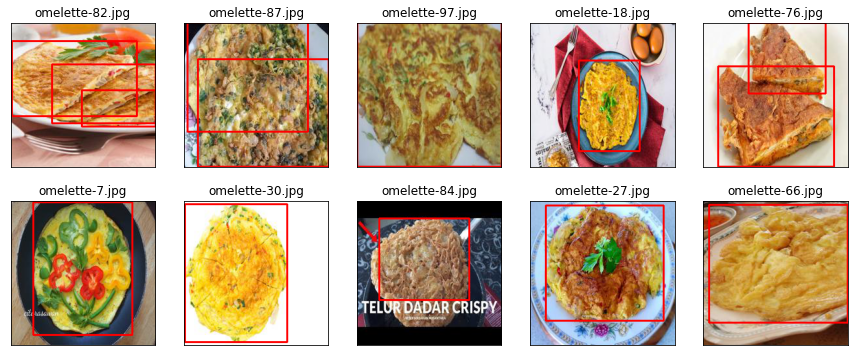

In [8]:
show_images('omelette', show_bbox=True)

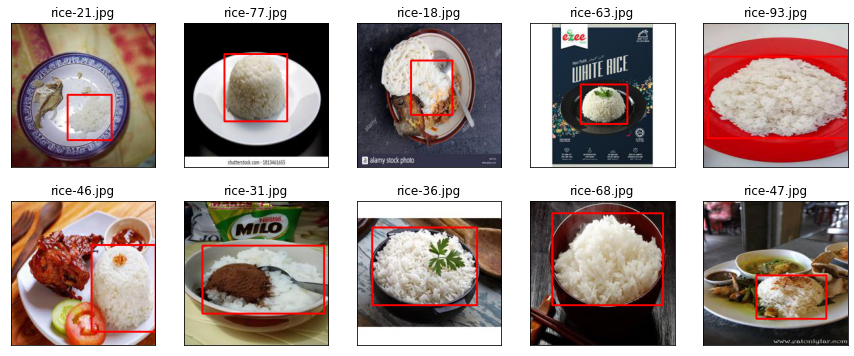

In [9]:
show_images('rice', show_bbox=True)

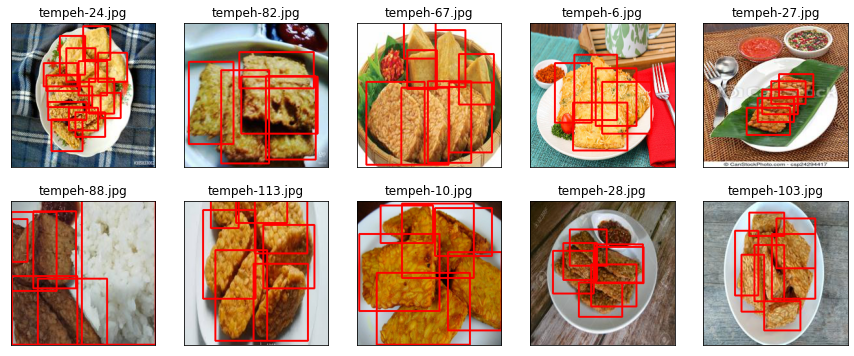

In [10]:
show_images('tempeh', show_bbox=True)

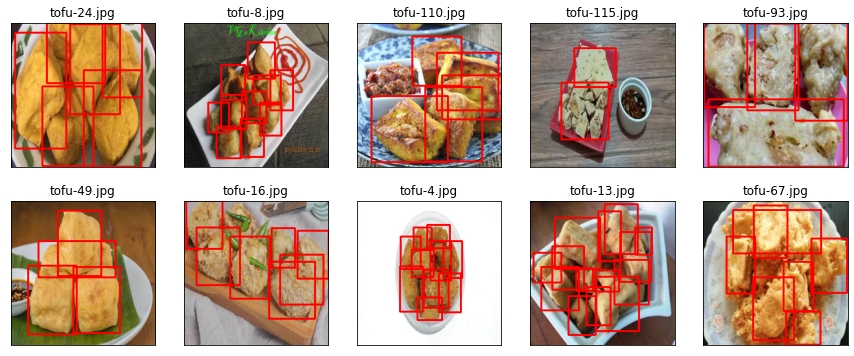

In [11]:
show_images('tofu', show_bbox=True)

## List the images

In [12]:
import subprocess

def create_image_path(data_split='train'):
    # Initialize the Google Cloud Storage (GCS) bucket
    bucket = 'gs://food-nutrition'
    # Define the dataset directory on GCS
    dataset_dir = '{}/dataset'.format(bucket)

    # Execute gsutil command to list train images
    command = 'gsutil ls -r {}/{}/*/*.jpg'.format(dataset_dir, data_split)
    img_path = subprocess.getoutput(command).split('\n')
    img_path = np.array(img_path)

    return img_path

In [13]:
train_img_path = create_image_path('train')
valid_img_path = create_image_path('validation')
test_img_path = create_image_path('test')

In [14]:
train_img_path[:5]

array(['gs://food-nutrition/dataset/train/omelette/omelette-1.jpg',
       'gs://food-nutrition/dataset/train/omelette/omelette-10.jpg',
       'gs://food-nutrition/dataset/train/omelette/omelette-101.jpg',
       'gs://food-nutrition/dataset/train/omelette/omelette-102.jpg',
       'gs://food-nutrition/dataset/train/omelette/omelette-103.jpg'],
      dtype='<U59')

In [15]:
valid_img_path[:5]

array(['gs://food-nutrition/dataset/validation/omelette/omelette-11.jpg',
       'gs://food-nutrition/dataset/validation/omelette/omelette-13.jpg',
       'gs://food-nutrition/dataset/validation/omelette/omelette-14.jpg',
       'gs://food-nutrition/dataset/validation/omelette/omelette-24.jpg',
       'gs://food-nutrition/dataset/validation/omelette/omelette-3.jpg'],
      dtype='<U63')

In [16]:
test_img_path[:5]

array(['gs://food-nutrition/dataset/test/omelette/omelette-100.jpg',
       'gs://food-nutrition/dataset/test/omelette/omelette-116.jpg',
       'gs://food-nutrition/dataset/test/omelette/omelette-118.jpg',
       'gs://food-nutrition/dataset/test/omelette/omelette-119.jpg',
       'gs://food-nutrition/dataset/test/omelette/omelette-59.jpg'],
      dtype='<U58')

In [17]:
print('Total training images:', len(train_img_path))
print('Total validation images:', len(valid_img_path))
print('Total testing images:', len(test_img_path))

Total training images: 400
Total validation images: 40
Total testing images: 40


## List the annotation

In [18]:
# Read the classes file
f = open('/content/dataset/predefined-classes.txt')
classes = f.read().splitlines()
classes = np.array(classes)
f.close()

In [19]:
def create_annotation_path(data_split='train'):
    # List all of annotation txt
    annotation_path = glob('/content/dataset/{}/*/*.txt'.format(data_split))
    # Remove all of classes.txt from list
    annotation_path = list(filter(lambda path: os.path.basename(path) != 'classes.txt', annotation_path))
    # Convert list to numpy array
    annotation_path = np.array(annotation_path)
    return annotation_path

In [20]:
train_annotation_path = create_annotation_path('train')
valid_annotation_path = create_annotation_path('validation')
test_annotation_path = create_annotation_path('test')

In [21]:
train_annotation_path[:5]

array(['/content/dataset/train/tofu/tofu-88.txt',
       '/content/dataset/train/tofu/tofu-101.txt',
       '/content/dataset/train/tofu/tofu-27.txt',
       '/content/dataset/train/tofu/tofu-63.txt',
       '/content/dataset/train/tofu/tofu-75.txt'], dtype='<U48')

In [22]:
valid_annotation_path[:5]

array(['/content/dataset/validation/tofu/tofu-39.txt',
       '/content/dataset/validation/tofu/tofu-54.txt',
       '/content/dataset/validation/tofu/tofu-33.txt',
       '/content/dataset/validation/tofu/tofu-9.txt',
       '/content/dataset/validation/tofu/tofu-21.txt'], dtype='<U52')

In [23]:
test_annotation_path[:5]

array(['/content/dataset/test/tofu/tofu-91.txt',
       '/content/dataset/test/tofu/tofu-104.txt',
       '/content/dataset/test/tofu/tofu-108.txt',
       '/content/dataset/test/tofu/tofu-106.txt',
       '/content/dataset/test/tofu/tofu-107.txt'], dtype='<U47')

In [24]:
print('Total training annotation:', len(train_annotation_path))
print('Total validation annotation:', len(valid_annotation_path))
print('Total testing annotation:', len(test_annotation_path))

Total training annotation: 400
Total validation annotation: 40
Total testing annotation: 40


## Convert YOLO Dataset to Vertex AI Dataset

Source: [Preparing image data](https://cloud.google.com/vertex-ai/docs/datasets/prepare-image#object-detection)

CSV format:
```
[ML_USE],GCS_FILE_PATH,[LABEL],[BOUNDING_BOX]*
```

List of columns
- **ML_USE (Optional)**. For data split purposes when training a model. Use TRAINING, TEST, or VALIDATION. For more information about manual data splitting, see About data splits for AutoML models.
- **GCS_FILE_PATH**. This field contains the Cloud Storage URI for the image. Cloud Storage URIs are case-sensitive.
- **LABEL**. Labels must start with a letter and only contain letters, numbers, and underscores.
- **BOUNDING_BOX**. A bounding box for an object in the image. Specifying a bounding box involves more than one column.

    - A. X_MIN,Y_MIN
    - B. X_MAX,Y_MIN
    - C. X_MAX,Y_MAX
    - D. X_MIN,Y_MAX

    Each vertex is specified by x, y coordinate values. Coordinates are normalized float values [0,1]; 0.0 is X_MIN or Y_MIN, 1.0 is X_MAX or Y_MAX.

    For example, a bounding box for the entire image is expressed as (0.0,0.0,,,1.0,1.0,,), or (0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0).

    The bounding box for an object can be specified in one of two ways:

    1. Two vertices (two sets of x,y coordinates) that are diagonally opposite points of the rectangle:
        - A. X_MIN,Y_MIN
        - C. X_MAX,Y_MAX

        as shown in this example:
        
        A,,C,
        
        X_MIN,Y_MIN,,,X_MAX,Y_MAX,,
    2. All four vertices specified as shown in:
        
        X_MIN,Y_MIN,X_MAX,Y_MIN, X_MAX,Y_MAX,X_MIN,Y_MAX,
        
        If the four specified vertices don't form a rectangle parallel to image edges, Vertex AI specifies vertices that do form such a rectangle.

In [25]:
def convert_yolo_to_vertex(annotation):
    # Get YOLO bounding boxes (bbox)
    x = annotation[:, 1].astype('float')
    y = annotation[:, 2].astype('float')
    w = annotation[:, 3].astype('float')
    h = annotation[:, 4].astype('float')

    # Convert YOLO bbox format to Vertex bbox format
    bbox_precision_point = 5 # berapa angka di belakang koma
    x_min = np.round((x - w / 2), bbox_precision_point)
    x_max = np.round((x + w / 2), bbox_precision_point)
    y_min = np.round((y - h / 2), bbox_precision_point)
    y_max = np.round((y + h / 2), bbox_precision_point)

    # Create vertex annotation
    vertex_annotation = np.empty((annotation.shape[0], 9), dtype='object')
    vertex_annotation[:, 0] = annotation[:, 0]
    vertex_annotation[:, 1:] = np.stack((x_min, y_min, x_max, y_min, x_max, y_max, x_min, y_max), axis=1)

    return vertex_annotation

def create_csv_matrix(images_path, annotation_path, csv_matrix, dataset_type='training'):
    for i, path in enumerate(annotation_path):
        # Read annotation from txt file
        annotation = np.loadtxt(path)

        # Skip the file if empty
        # if annotation.size == 0: continue

        # Reshape numpy array to make sure 2D array and 
        # astype to object so the array can save many data type (string, float)
        annotation = annotation.reshape((-1, 5)).astype('object')
        # Convert numerical labels to categorical labels
        labels = classes[annotation[:, 0].astype('int')]
        # Change the numerical labels from annotation
        annotation[:, 0] = labels

        # Create vertex annotation
        vertex_annotation = convert_yolo_to_vertex(annotation)

        # Get file name from path
        file_name = os.path.basename(path).split('.')[0]
        # Create lambda function for searching image file
        search_file_function = (lambda path: os.path.basename(path) == '{}.jpg'.format(file_name))
        # Get image path using filter function
        img_path = list(filter(search_file_function, images_path))[0]

        # Insert row data to be like this: [IMG_PATH,LABEL,X_MIN,Y_MIN,X_MAX,Y_MIN,X_MAX,Y_MAX,X_MIN,Y_MAX]
        csv_row = np.insert(vertex_annotation, 0, img_path, axis=1)
        # Insert row data to be like this: [DATA_SPLIT,IMG_PATH,LABEL,X_MIN,Y_MIN,X_MAX,Y_MIN,X_MAX,Y_MAX,X_MIN,Y_MAX]
        csv_row = np.insert(csv_row, 0, dataset_type, axis=1)

        # Insert row data to csv matrix
        csv_matrix = np.vstack((csv_matrix, csv_row))
    
    return csv_matrix

In [26]:
# Total cols in csv file in Vertex AI format
ncols = 11

csv_matrix = np.array([]).reshape((0, ncols))
csv_matrix = create_csv_matrix(train_img_path, train_annotation_path, csv_matrix, dataset_type='training')
csv_matrix = create_csv_matrix(valid_img_path, valid_annotation_path, csv_matrix, dataset_type='validation')
csv_matrix = create_csv_matrix(test_img_path, test_annotation_path, csv_matrix, dataset_type='test')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: UserWarning: loadtxt: Empty input file: "/content/dataset/train/tofu/tofu-60.txt"
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: UserWarning: loadtxt: Empty input file: "/content/dataset/train/tofu/tofu-10.txt"
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: UserWarning: loadtxt: Empty input file: "/content/dataset/train/tofu/tofu-86.txt"
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: UserWarning: loadtxt: Empty input file: "/content/dataset/train/tofu/tofu-94.txt"
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: UserWarning: loadtxt: Empty input file: "/content/dataset/train/rice/rice-97.txt"
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: UserWarning: loadtxt: Empty input file: "/content/dataset/validation/tofu/tofu-9.txt"
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: UserWarning: loadtxt: Empty input file: "/content

In [27]:
csv_matrix[82]

array(['training', 'gs://food-nutrition/dataset/train/tofu/tofu-110.jpg',
       'tofu', 0.58482, 0.37054, 1.0, 0.37054, 1.0, 0.67411, 0.58482,
       0.67411], dtype=object)

In [28]:
import pandas as pd

# Convert csv matrix to dataframe
df = pd.DataFrame(csv_matrix)
# Save csv matrix to csv file
df.to_csv('food-data.csv', header=False, index=False)

## Upload dataset to Google Cloud Storage

In [29]:
# Upload dataset to our bucket
!gsutil -m cp -r /content/food-data.csv gs://food-nutrition/vertex-dataset/

Copying file:///content/food-data.csv [Content-Type=text/csv]...
-
Operation completed over 1 objects/244.4 KiB.                                    


In [30]:
# Make sure the file has been uploaded successfully 
!gsutil ls gs://food-nutrition/vertex-dataset/

gs://food-nutrition/vertex-dataset/food-data.csv
